In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
!ls drive/My\ Drive/zindi

01.first_try_with_splitted_spec.ipynb
01.spectrograms_all_loop1.h5
01.spectrograms_all_loop2.h5
01.spectrograms_all_loop3.h5
01.spectrograms_first_try_batch_size_32_loop.h5
02_spec_all.ipynb
03_spectrograms_CNN_clean_finished_1st_part_final.ipynb
04_spectrograms_catboost_A_FINIR_.ipynb
05_other_features.ipynb
audio_signal_3d.jpeg
Graph
other_features_random_forrest_clf.csv
references
SampleSubmission.csv
Spectrograms_1_Train
Spectrograms_2_Test
Spectrograms_all_classified
Spectrograms_splitted_classified
submission_iteration_1.csv
submission_iteration_2.csv
submission_iteration_3.csv
Test
Test.csv
test_other_features.csv
Train
Train.csv
train_other_features.csv
viz.png
x_test.csv
x_train.csv


In [0]:
import pandas as pd
import numpy as np

import IPython.display as ipd
from matplotlib import pyplot as plt
import seaborn as sns

import librosa # package for music and audio processing, & features extraction 
import os, shutil, glob

In [0]:
path_colab = 'drive/My Drive/zindi/'
path_jupyt = './'

# set to True with colab or False with jupyter
colab = True
path = path_colab if colab else path_jupyt

## Take a look at the submission 

In [5]:
sub = pd.read_csv(path + 'SampleSubmission.csv')

# retrieve all the class names in a list (the 1st col is the id)
birds = sub.columns[1:]

# add a col with all files' paths 
sub['file_path'] = path + 'Test/' + sub['ID'] + '.mp3'
sub.head()

,ID,Ring-necked Dove,Black Cuckoo,Red-chested Cuckoo,Fiery-necked Nightjar,Green Wood Hoopoe,Crested Barbet,Cape Batis,Olive Bushshrike,Orange-breasted Bushshrike,Bokmakierie,Black-backed Puffback,Southern Boubou,Black-headed Oriole,Fork-tailed Drongo,African Paradise Flycatcher,Sabota Lark,Eastern Clapper Lark,Rufous-naped Lark,Dark-capped Bulbul,Sombre Greenbul,Long-billed Crombec,African Reed Warbler,Rattling Cisticola,Levaillants Cisticola,Tawny-flanked Prinia,Karoo Prinia,Bar-throated Apalis,Green-backed Camaroptera,Chestnut-vented Warbler,Cape White-eye,Karoo Scrub Robin,White-browed Scrub Robin,Cape Robin-Chat,White-browed Robin-Chat,Chorister Robin-Chat,Southern Double-collared Sunbird,White-bellied Sunbird,African Pipit,African Rock Pipit,Cape Bunting,file_path
0,019OYB,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,drive/My Drive/zindi/Test/019OYB.mp3
1,01S9OX,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,drive/My Drive/zindi/Test/01S9OX.mp3
2,02CS12,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,drive/My Drive/zindi/Test/02CS12.mp3
3,02LM3W,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,drive/My Drive/zindi/Test/02LM3W.mp3
4,0C3A2V,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,drive/My Drive/zindi/Test/0C3A2V.mp3


List of species:

In [6]:
birds.values

array(['Ring-necked Dove', 'Black Cuckoo', 'Red-chested Cuckoo',
       'Fiery-necked Nightjar', 'Green Wood Hoopoe', 'Crested Barbet',
       'Cape Batis', 'Olive Bushshrike', 'Orange-breasted Bushshrike',
       'Bokmakierie', 'Black-backed Puffback', 'Southern Boubou',
       'Black-headed Oriole', 'Fork-tailed Drongo',
       'African Paradise Flycatcher', 'Sabota Lark',
       'Eastern Clapper Lark', 'Rufous-naped Lark', 'Dark-capped Bulbul',
       'Sombre Greenbul', 'Long-billed Crombec', 'African Reed Warbler',
       'Rattling Cisticola', 'Levaillants Cisticola',
       'Tawny-flanked Prinia', 'Karoo Prinia', 'Bar-throated Apalis',
       'Green-backed Camaroptera', 'Chestnut-vented Warbler',
       'Cape White-eye', 'Karoo Scrub Robin', 'White-browed Scrub Robin',
       'Cape Robin-Chat', 'White-browed Robin-Chat',
       'Chorister Robin-Chat', 'Southern Double-collared Sunbird',
       'White-bellied Sunbird', 'African Pipit', 'African Rock Pipit',
       'Cape Bunting'], 

In [7]:
# check if ID are alphabetically ordered
col_id = list(sub['ID'].values)
col_id == sorted(list(sub['ID'].values))

True

In [8]:
sub['len'] = sub['ID'].apply(lambda x: len(x))
sub['len'].value_counts()

6    911
Name: len, dtype: int64

In [9]:
nb_class = len(birds)
nb_class

40

## The train dataset & images

In [10]:
# same thing with train
train = pd.read_csv(path + 'Train.csv')
train['file_path'] = path + 'Train/' + train['ID'] + '.mp3'
train.head()

,ID,common_name,file_path
0,MBMG2C,Ring-necked Dove,drive/My Drive/zindi/Train/MBMG2C.mp3
1,K8LJSB,Ring-necked Dove,drive/My Drive/zindi/Train/K8LJSB.mp3
2,OGD9L6,Ring-necked Dove,drive/My Drive/zindi/Train/OGD9L6.mp3
3,581PCQ,Ring-necked Dove,drive/My Drive/zindi/Train/581PCQ.mp3
4,P91M1F,Ring-necked Dove,drive/My Drive/zindi/Train/P91M1F.mp3


In [11]:
train['file_path'] = path + 'Spectrograms_1_Train/' + train['ID'] + '.png'
train.head()

,ID,common_name,file_path
0,MBMG2C,Ring-necked Dove,drive/My Drive/zindi/Spectrograms_1_Train/MBMG...
1,K8LJSB,Ring-necked Dove,drive/My Drive/zindi/Spectrograms_1_Train/K8LJ...
2,OGD9L6,Ring-necked Dove,drive/My Drive/zindi/Spectrograms_1_Train/OGD9...
3,581PCQ,Ring-necked Dove,drive/My Drive/zindi/Spectrograms_1_Train/581P...
4,P91M1F,Ring-necked Dove,drive/My Drive/zindi/Spectrograms_1_Train/P91M...


# Creation of the train data set

In [12]:
headers = 'filename chroma_stft rmse spectral_centroid spectral_bandwidth rolloff zero_crossing_rate'.split()
headers.extend([f' mfcc{i}' for i in range(1, 21)])
headers = ','.join(headers) + '\n'

with open('drive/My Drive/zindi/train_other_features.csv', 'w') as f:
    f.write(headers)


for file_name in os.listdir('drive/My Drive/zindi/Train'):
    y, sr = librosa.load('drive/My Drive/zindi/Train/' + file_name) # , mono=True
    try:
        chroma_stft = librosa.feature.chroma_stft(y=y, sr=sr)
        rmse = librosa.feature.rms(y=y)
        spec_cent = librosa.feature.spectral_centroid(y=y, sr=sr)
        spec_bw = librosa.feature.spectral_bandwidth(y=y, sr=sr)
        rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr)
        zcr = librosa.feature.zero_crossing_rate(y)
        mfcc = librosa.feature.mfcc(y=y, sr=sr)
    except:
        print(f'problem to extract features for file: {file_name}')
    new_line = f'{file_name} {np.mean(chroma_stft)} {np.mean(rmse)} {np.mean(spec_cent)} {np.mean(spec_bw)} {np.mean(rolloff)} {np.mean(zcr)}'    
    for e in mfcc:
        new_line += f' {np.mean(e)}'
    new_line = new_line.replace(' ', ',') + '\n'
    with open('drive/My Drive/zindi/train_other_features.csv', 'a') as f:
        f.write(new_line)

/usr/local/lib/python3.6/dist-packages/librosa/core/pitch.py:145: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn('Trying to estimate tuning from empty frequency set.')
/usr/local/lib/python3.6/dist-packages/librosa/core/pitch.py:145: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn('Trying to estimate tuning from empty frequency set.')


In [14]:
df = pd.read_csv('drive/My Drive/zindi/train_other_features.csv')
df['ID'] = df['filename'].apply(lambda x: x[:-4])
df = df.join(train.set_index('ID'), on='ID')
df = df.drop(columns=['filename', 'ID',	'file_path'])
df.head()

,chroma_stft,rmse,spectral_centroid,spectral_bandwidth,rolloff,zero_crossing_rate,mfcc1,mfcc2,mfcc3,mfcc4,mfcc5,mfcc6,mfcc7,mfcc8,mfcc9,mfcc10,mfcc11,mfcc12,mfcc13,mfcc14,mfcc15,mfcc16,mfcc17,mfcc18,mfcc19,mfcc20,common_name
0,0.481558,0.014304,2813.813080,2711.237011,5913.258499,0.148155,-319.529041,72.292708,14.862157,32.460908,-12.969841,-15.898284,-15.586416,-13.956589,-18.368180,-11.084914,-16.270154,-6.809838,-13.204864,-4.956509,-7.851389,-4.269312,-9.225667,-1.159027,-8.369622,-3.497214,Sombre Greenbul
1,0.281237,0.101893,4987.553879,1755.854626,6302.180695,0.456716,-190.536584,-12.816435,17.682109,28.118785,-44.390018,41.692232,-39.699796,14.915158,-1.940447,-18.581102,5.559155,-10.620004,-11.066929,-5.022316,-17.744583,0.533043,-14.171363,-3.831862,-8.337654,-3.116458,Fork-tailed Drongo
2,0.316430,0.016173,4284.497724,1611.593584,5624.660810,0.389774,-438.200421,-82.139249,-110.736678,43.904056,-21.163486,28.067891,-15.173169,-6.959926,-3.034636,-12.806958,2.125802,-10.244592,-0.855434,5.938562,-2.765048,5.807921,-6.377669,2.168181,-3.377103,-2.026902,Karoo Prinia
3,0.581339,0.028113,4123.560689,3374.205178,8087.157041,0.286957,-218.029774,63.711802,30.848129,3.262415,23.343046,4.093092,2.690266,30.256911,-20.380495,30.123023,-12.900337,12.211247,-3.389328,0.311240,-2.642381,-0.538888,-4.574622,-1.847099,-6.776262,-0.643363,Sombre Greenbul
4,0.474624,0.013756,2028.850556,2360.227108,4080.911505,0.093436,-407.077717,77.558757,-3.754847,40.676203,22.529827,13.422598,14.427485,27.536358,13.470498,8.572629,16.235137,13.540927,1.560348,5.168728,8.523573,3.967189,-2.527771,6.102171,0.563315,-1.856384,Orange-breasted Bushshrike


In [0]:
https://github.com/parulnith/Music-Genre-Classification-with-Python/blob/master/Music_genre_classification.ipynb

In [15]:
df.shape

(1857, 27)

# Creation of the test data set

In [0]:
headers = 'filename chroma_stft rmse spectral_centroid spectral_bandwidth rolloff zero_crossing_rate'.split()
headers.extend([f' mfcc{i}' for i in range(1, 21)])
headers = ','.join(headers) + '\n'

with open('drive/My Drive/zindi/test_other_features.csv', 'w') as f:
    f.write(headers)

with open('drive/My Drive/zindi/test_other_features.csv', 'a') as f:
    for file_name in os.listdir('drive/My Drive/zindi/Test'):
        y, sr = librosa.load('drive/My Drive/zindi/Test/' + file_name) # , mono=True
        try:
            chroma_stft = librosa.feature.chroma_stft(y=y, sr=sr)
            rmse = librosa.feature.rms(y=y)
            spec_cent = librosa.feature.spectral_centroid(y=y, sr=sr)
            spec_bw = librosa.feature.spectral_bandwidth(y=y, sr=sr)
            rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr)
            zcr = librosa.feature.zero_crossing_rate(y)
            mfcc = librosa.feature.mfcc(y=y, sr=sr)
        except:
            print(f'problem to extract features for file: {file_name}')
        new_line = f'{file_name} {np.mean(chroma_stft)} {np.mean(rmse)} {np.mean(spec_cent)} {np.mean(spec_bw)} {np.mean(rolloff)} {np.mean(zcr)}'    
        for e in mfcc:
            new_line += f' {np.mean(e)}'
        new_line = new_line.replace(' ', ',') + '\n'
        f.write(new_line)

/usr/local/lib/python3.6/dist-packages/librosa/core/pitch.py:145: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn('Trying to estimate tuning from empty frequency set.')
/usr/local/lib/python3.6/dist-packages/librosa/core/pitch.py:145: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn('Trying to estimate tuning from empty frequency set.')


In [16]:
df_test = pd.read_csv('drive/My Drive/zindi/test_other_features.csv')
df_test['ID'] = df_test['filename'].apply(lambda x: x[:-4])
df_test = pd.DataFrame(sub['ID']).join(df_test.set_index('ID'), on='ID')
df_test = df_test.drop(columns=['filename'])
df_test.head()

,ID,chroma_stft,rmse,spectral_centroid,spectral_bandwidth,rolloff,zero_crossing_rate,mfcc1,mfcc2,mfcc3,mfcc4,mfcc5,mfcc6,mfcc7,mfcc8,mfcc9,mfcc10,mfcc11,mfcc12,mfcc13,mfcc14,mfcc15,mfcc16,mfcc17,mfcc18,mfcc19,mfcc20
0,019OYB,0.313510,0.008095,3411.380109,2451.747710,6132.731059,0.248263,-501.327069,32.109317,-38.798032,-7.169688,5.442865,14.384776,-12.949904,-12.496355,5.421788,-2.466916,-6.234134,-0.505081,-2.492379,7.884158,-10.326314,-7.142869,-0.421185,-10.064852,-10.543456,-0.983980
1,01S9OX,0.534741,0.006644,2136.448904,2230.428352,4022.811811,0.128201,-390.104404,108.967341,-19.471324,-8.184451,-10.650116,-4.773568,-4.982807,3.225590,-9.871317,-4.571195,-8.569492,-0.337286,-5.173132,-1.638916,-3.492512,0.817993,-6.118737,0.436864,-1.589846,1.731289
2,02CS12,0.753536,0.009483,1285.031734,2393.041677,3032.536256,0.026788,-477.035785,101.181484,34.049179,35.127273,20.001914,18.402255,11.514492,15.610092,5.725882,11.621233,4.790286,9.676952,3.255548,7.757688,1.502075,6.890717,1.057512,6.243687,0.394042,5.527093
3,02LM3W,0.395092,0.027995,1985.356364,2042.408718,3669.857396,0.097758,-328.783845,91.410286,-26.072201,19.434099,-8.146481,-2.406203,-2.757944,20.768118,25.052868,29.376524,-2.162842,-0.522631,7.260789,17.411985,9.800333,6.916292,4.018382,6.274621,-3.448071,-4.713149
4,0C3A2V,0.386995,0.007158,2931.958573,2018.733095,4829.411958,0.244541,-366.934113,65.804678,-55.437294,5.806266,-44.263203,-18.366936,-35.448660,0.285588,-20.968330,-19.590870,-8.078673,-6.148230,-20.775619,-9.204046,-15.225978,-7.482268,-8.557184,-7.137101,-7.499523,-1.098366


In [17]:
df_test.shape

(911, 27)

# Exploratory Data Analysis

In [18]:
df.describe()

,chroma_stft,rmse,spectral_centroid,spectral_bandwidth,rolloff,zero_crossing_rate,mfcc1,mfcc2,mfcc3,mfcc4,mfcc5,mfcc6,mfcc7,mfcc8,mfcc9,mfcc10,mfcc11,mfcc12,mfcc13,mfcc14,mfcc15,mfcc16,mfcc17,mfcc18,mfcc19,mfcc20
count,1857.000000,1857.000000,1857.000000,1857.000000,1857.000000,1857.000000,1857.000000,1857.000000,1857.000000,1857.000000,1857.000000,1857.000000,1857.000000,1857.000000,1857.000000,1857.000000,1857.000000,1857.000000,1857.000000,1857.000000,1857.000000,1857.000000,1857.000000,1857.000000,1857.000000,1857.000000
mean,0.446200,0.028981,3336.091313,2210.269334,5604.644841,0.249062,-364.508322,29.039583,-39.311099,13.145904,-10.657878,2.937985,-3.988720,3.064352,-5.277999,1.951272,-3.719950,-0.300779,-3.963940,2.035230,-2.219999,0.627754,-2.555254,0.810032,-3.174046,0.927965
std,0.113051,0.029997,965.577129,469.694917,1481.359192,0.105917,100.692883,56.669984,41.563428,27.456821,20.475802,16.496901,13.887812,12.506400,10.803153,9.829344,8.271505,7.979139,6.658157,6.226892,6.182349,5.391375,5.278487,4.570138,4.434346,4.238973
min,0.139431,0.000210,434.095351,446.841006,462.032975,0.007997,-936.224548,-273.446501,-188.364144,-127.434631,-106.113715,-57.886672,-70.236958,-45.060977,-53.465832,-39.759810,-49.033050,-32.163299,-42.969416,-21.127237,-24.767287,-25.471631,-21.831622,-17.308499,-24.751762,-21.746538
25%,0.360854,0.011196,2676.971521,1903.373993,4660.834058,0.172650,-426.577657,-5.985399,-70.072698,-2.102970,-23.619645,-7.856992,-12.889759,-5.412282,-12.443433,-4.720947,-9.145751,-5.336441,-8.192145,-2.092352,-5.888004,-2.843542,-5.968502,-1.903212,-5.961847,-1.856384
50%,0.442416,0.019961,3363.460120,2234.846319,5686.850487,0.251975,-366.845270,34.805178,-36.642340,14.893194,-10.388204,3.016748,-4.063000,2.525932,-5.108847,1.649623,-3.948860,-0.474406,-3.740847,2.085774,-2.405760,0.972302,-2.532651,1.046603,-3.191599,1.108129
75%,0.523261,0.035709,3974.441235,2543.761032,6656.820972,0.316990,-301.433617,67.054467,-8.971238,30.113618,2.913480,13.321520,5.380051,11.479679,1.898378,8.050035,1.703910,4.524594,0.454197,5.851556,1.392756,4.050149,0.557871,3.633971,-0.576875,3.561597
max,0.769121,0.301758,8313.998349,3594.638361,10165.712797,0.759106,-67.194684,203.109857,79.127097,137.487499,66.488852,78.616681,49.318386,55.230019,35.874303,52.900645,38.072378,41.115163,20.161074,40.386432,40.016909,33.025325,21.635642,27.539719,21.925976,21.267871


In [19]:
feat = df.columns[:-1]
feat

Index(['chroma_stft', 'rmse', 'spectral_centroid', 'spectral_bandwidth',
       'rolloff', 'zero_crossing_rate', ' mfcc1', ' mfcc2', ' mfcc3', ' mfcc4',
       ' mfcc5', ' mfcc6', ' mfcc7', ' mfcc8', ' mfcc9', ' mfcc10', ' mfcc11',
       ' mfcc12', ' mfcc13', ' mfcc14', ' mfcc15', ' mfcc16', ' mfcc17',
       ' mfcc18', ' mfcc19', ' mfcc20'],
      dtype='object')

In [22]:
for f in feat:
  plt.figure(figsize=(14, 4))
  # axis x text vertically
  #plt.xticks(rotation=90)
  plt.title(f)
  #plt.axis('off')
  plt.xticks(color='w')
  sns.violinplot(x="common_name", y=f, data=df)   
  # the same thing can be done with barplot
  plt.show()

Output hidden; open in https://colab.research.google.com to view.

In [23]:
species = df['common_name'].unique()
for f in feat:
    plt.figure(figsize=(12, 5))
    for s in species:
        sns.distplot(df[df['common_name'] == s][f], hist=False)
    plt.title(f"Distribution of the {f} for each specy")
    plt.show()

Output hidden; open in https://colab.research.google.com to view.

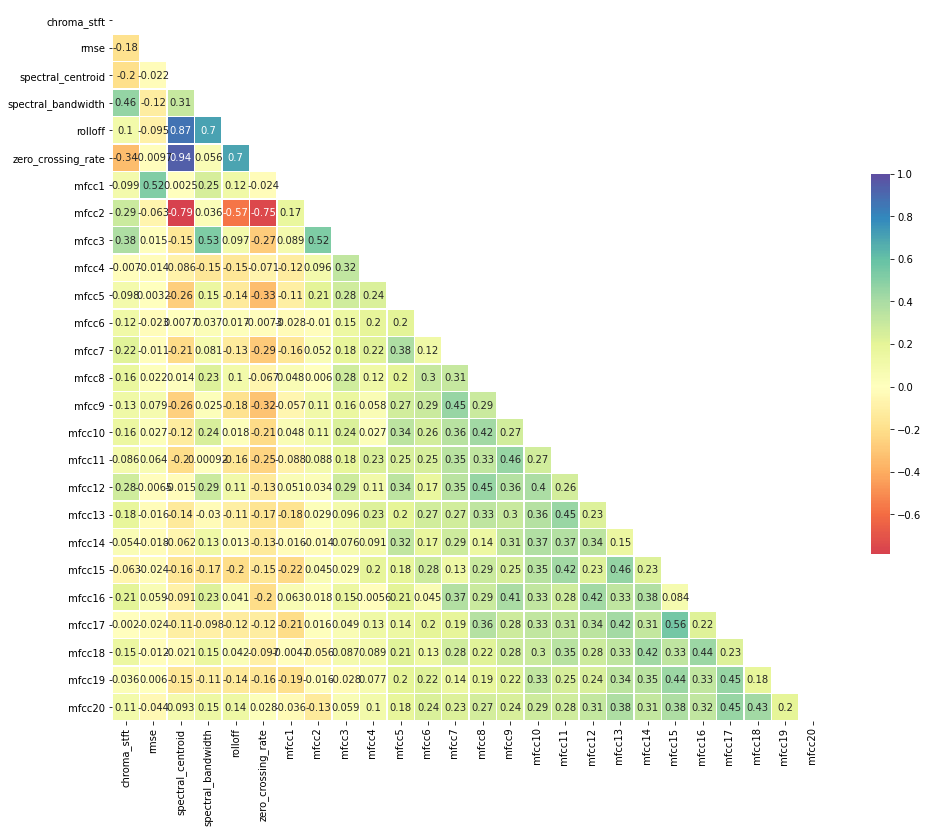

In [25]:
def plot_corr(df_):
    corr = df_.corr()
    corr

    # Generate a mask for the upper triangle
    mask = np.zeros_like(corr, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True

    # Set up the matplotlib figure
    f, ax = plt.subplots(figsize=(16, 14))

    # Generate a custom diverging colormap
    #cmap = sns.diverging_palette(220, 10, as_cmap=True)

    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(corr, mask=mask, center=0, square=True, cmap='Spectral', linewidths=.5, cbar_kws={"shrink": .5}, annot=True) #annot=True


plot_corr(df[feat])

In [26]:
X, y = df.drop(columns=['common_name']), df["common_name"]

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1485, 26), (372, 26), (1485,), (372,))

In [0]:
# https://stackabuse.com/overview-of-classification-methods-in-python-with-scikit-learn/
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.linear_model import LogisticRegression

import xgboost as xgb
import lightgbm as lgbm
#import catboost import CatBoostClassifier

from sklearn.metrics import accuracy_score

In [0]:
def get_accurary(clf, model_name):
    """Print the accurcies for the model passed in argument and retrun the values for the train/test sets"""
    y_train_pred, y_pred = clf.predict(X_train), clf.predict(X_test)
    acc_train, acc_test = float(accuracy_score(y_train, y_train_pred)), float(accuracy_score(y_test, y_pred))
    print(model_name, f'\t - ACC on Training  = {acc_train:.2f} / ACC on Test = {acc_test:.2f}')
    return acc_train, acc_test

In [0]:
# list of all the basic models used at first
model_list = [
      KNeighborsClassifier(),
      SVC(),
      GaussianProcessClassifier(),
      GaussianNB(),
      QuadraticDiscriminantAnalysis(),
      MLPClassifier(),
      DecisionTreeClassifier(),
      ExtraTreesClassifier(),
      xgb.XGBClassifier(),
      lgbm.LGBMClassifier(),
      RandomForestClassifier(n_estimators=10),
      GradientBoostingClassifier(),
      AdaBoostClassifier(),
      LogisticRegression()
      #CatBoostClassifier()
      ]

In [30]:
# GradientBoostingRegressor(), (), , lgbm.LGBMRegressor(), catboost
             
# creation of list of names and scores for the train / test
model_names = [str(m)[:str(m).index('(')] for m in model_list]
scores_train, scores_test = [], []

# fit and predict all models
for model, name in zip(model_list, model_names):
    model.fit(X_train, y_train)
    acc_train, acc_test = get_accurary(model, name)
    scores_train.append(acc_train)
    scores_test.append(acc_test)

KNeighborsClassifier 	 - ACC on Training  = 0.32 / ACC on Test = 0.06
SVC 	 - ACC on Training  = 0.07 / ACC on Test = 0.05
GaussianProcessClassifier 	 - ACC on Training  = 1.00 / ACC on Test = 0.06
GaussianNB 	 - ACC on Training  = 0.27 / ACC on Test = 0.16
QuadraticDiscriminantAnalysis 	 - ACC on Training  = 0.89 / ACC on Test = 0.19


/usr/local/lib/python3.6/dist-packages/sklearn/discriminant_analysis.py:691: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


MLPClassifier 	 - ACC on Training  = 0.08 / ACC on Test = 0.08
DecisionTreeClassifier 	 - ACC on Training  = 1.00 / ACC on Test = 0.12
ExtraTreesClassifier 	 - ACC on Training  = 1.00 / ACC on Test = 0.28
XGBClassifier 	 - ACC on Training  = 0.99 / ACC on Test = 0.26
LGBMClassifier 	 - ACC on Training  = 1.00 / ACC on Test = 0.27
RandomForestClassifier 	 - ACC on Training  = 0.99 / ACC on Test = 0.18
GradientBoostingClassifier 	 - ACC on Training  = 1.00 / ACC on Test = 0.21
AdaBoostClassifier 	 - ACC on Training  = 0.10 / ACC on Test = 0.10
LogisticRegression 	 - ACC on Training  = 0.13 / ACC on Test = 0.10


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [31]:
df_score = pd.DataFrame({'model_names' : model_names,
                         'scores_train' : scores_train,
                         'scores_test' : scores_test})
df_score = pd.melt(df_score, id_vars=['model_names'], value_vars=['scores_train', 'scores_test'])
df_score.head(10)

,model_names,variable,value
0,KNeighborsClassifier,scores_train,0.320539
1,SVC,scores_train,0.074074
2,GaussianProcessClassifier,scores_train,1.000000
3,GaussianNB,scores_train,0.268013
4,QuadraticDiscriminantAnalysis,scores_train,0.890909
5,MLPClassifier,scores_train,0.078114
6,DecisionTreeClassifier,scores_train,1.000000
7,ExtraTreesClassifier,scores_train,1.000000
8,XGBClassifier,scores_train,0.990572
9,LGBMClassifier,scores_train,1.000000


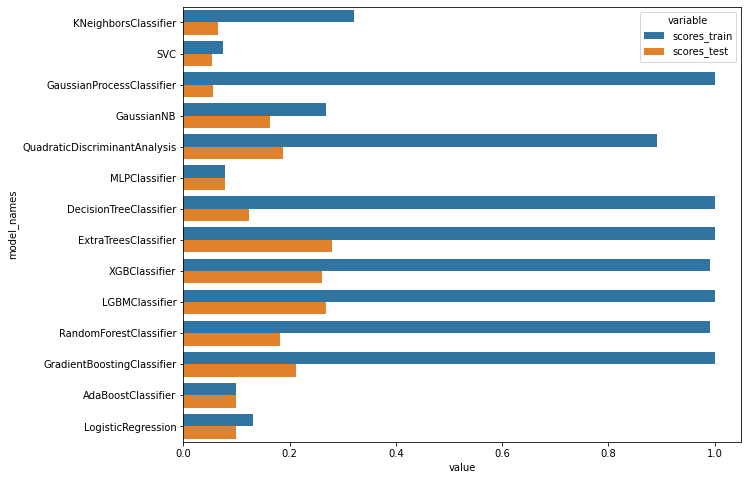

In [33]:
plt.figure(figsize=(10, 8))
sns.barplot(y="model_names", x="value", hue="variable", data=df_score)

In [34]:
rf_clf = RandomForestClassifier().fit(X, y)
y_pred = rf_clf.predict_proba(df_test.drop(columns=['ID']))
y_pred = pd.DataFrame(y_pred, columns=rf_clf.classes_)
y_pred = pd.concat([sub['ID'], y_pred], axis=1)
y_pred.head()

,ID,African Paradise Flycatcher,African Pipit,African Reed Warbler,African Rock Pipit,Bar-throated Apalis,Black Cuckoo,Black-backed Puffback,Black-headed Oriole,Bokmakierie,Cape Batis,Cape Bunting,Cape Robin-Chat,Cape White-eye,Chestnut-vented Warbler,Chorister Robin-Chat,Crested Barbet,Dark-capped Bulbul,Eastern Clapper Lark,Fiery-necked Nightjar,Fork-tailed Drongo,Green Wood Hoopoe,Green-backed Camaroptera,Karoo Prinia,Karoo Scrub Robin,Levaillants Cisticola,Long-billed Crombec,Olive Bushshrike,Orange-breasted Bushshrike,Rattling Cisticola,Red-chested Cuckoo,Ring-necked Dove,Rufous-naped Lark,Sabota Lark,Sombre Greenbul,Southern Boubou,Southern Double-collared Sunbird,Tawny-flanked Prinia,White-bellied Sunbird,White-browed Robin-Chat,White-browed Scrub Robin
0,019OYB,0.00,0.04,0.00,0.00,0.01,0.09,0.02,0.05,0.05,0.02,0.00,0.01,0.00,0.02,0.02,0.06,0.02,0.00,0.08,0.04,0.00,0.01,0.01,0.01,0.02,0.01,0.04,0.04,0.06,0.01,0.00,0.00,0.04,0.02,0.03,0.01,0.01,0.07,0.05,0.03
1,01S9OX,0.01,0.01,0.00,0.01,0.01,0.00,0.05,0.07,0.06,0.03,0.00,0.03,0.00,0.26,0.00,0.00,0.01,0.09,0.00,0.03,0.00,0.02,0.00,0.00,0.00,0.00,0.06,0.00,0.00,0.01,0.02,0.00,0.00,0.12,0.04,0.01,0.00,0.01,0.00,0.04
2,02CS12,0.01,0.00,0.03,0.01,0.03,0.00,0.01,0.01,0.00,0.01,0.01,0.02,0.00,0.01,0.00,0.00,0.42,0.04,0.00,0.13,0.09,0.01,0.03,0.00,0.00,0.01,0.00,0.00,0.01,0.00,0.01,0.03,0.01,0.00,0.01,0.00,0.02,0.01,0.00,0.02
3,02LM3W,0.02,0.00,0.00,0.00,0.04,0.00,0.05,0.06,0.04,0.05,0.00,0.02,0.00,0.07,0.03,0.09,0.00,0.01,0.01,0.04,0.00,0.02,0.00,0.00,0.00,0.02,0.00,0.00,0.00,0.04,0.11,0.02,0.00,0.00,0.04,0.01,0.03,0.01,0.02,0.15
4,0C3A2V,0.01,0.01,0.03,0.02,0.01,0.03,0.05,0.02,0.00,0.03,0.02,0.07,0.06,0.02,0.04,0.00,0.00,0.04,0.00,0.05,0.00,0.05,0.02,0.02,0.02,0.00,0.01,0.01,0.00,0.01,0.04,0.02,0.02,0.06,0.04,0.11,0.00,0.00,0.03,0.03


In [0]:
y_pred.to_csv('drive/My Drive/zindi/other_features_random_forrest_clf.csv')

In [0]:
y_pred = rf_clf.predict_proba(df.drop(columns=['common_name']))
y_pred = np.argmax(y_pred, axis=1)
y_pred = [rf_clf.classes_[t] for t in y_pred]
y_true = train['common_name'].values

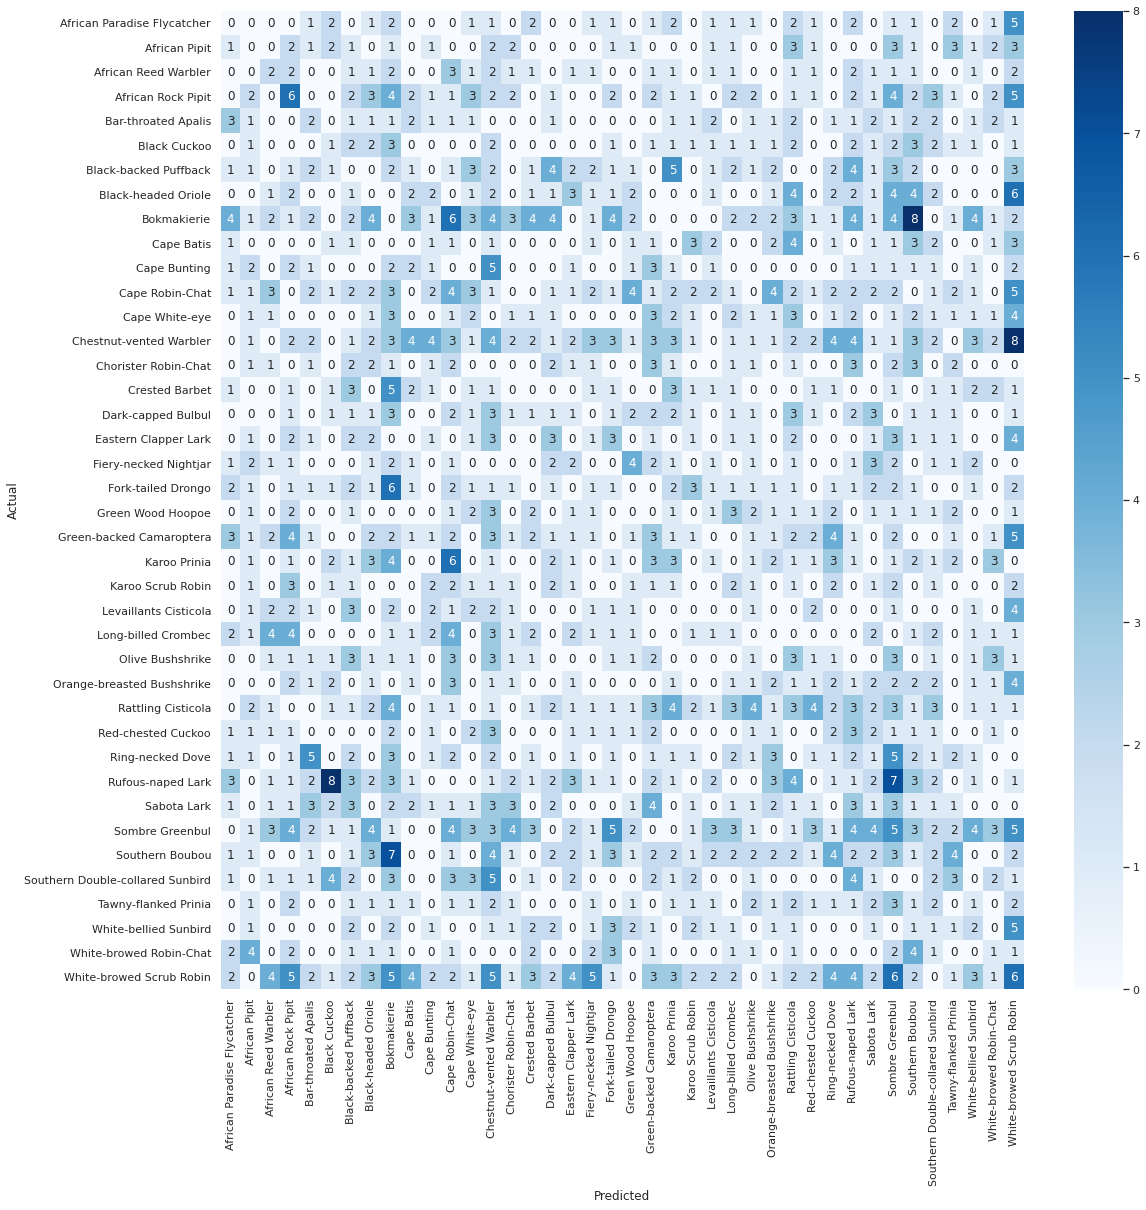

In [46]:
from sklearn.metrics import confusion_matrix
# since v0.22 sklearn has a specific method to plot confusion matrix

cm = confusion_matrix(y_true, y_pred)

df_cm = pd.DataFrame(cm, columns=np.unique(y_true), index = np.unique(y_true))
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize = (18, 18))
sns.set(font_scale=1) #for label size
sns.heatmap(df_cm, cmap="Blues", annot=True,annot_kws={"size": 12})# font size